<a href="https://colab.research.google.com/github/nightted/ML-LeeHongYi-HW/blob/master/HW_7_Network_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Compression

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image 
import matplotlib.pyplot as plt

#MoblieNet

In [ ]:
# Define Student-Net : MobileNet
class StudentNet(nn.Module):

  def __init__(self, b_size = 16 , width_multi = 1):

    super(StudentNet,self).__init__()
    # Define the sub_blok size
    block_multiplier = [1, 2, 4, 8, 16, 16, 16, 16]
    block_size = [b_size*size for size in block_multiplier]

    #Unknown method 照做XD
    for i in range(3,7):
      block_size[i] = int(block_size[i]*width_multi) # width_multi as pourning ratio 

    self.cnn = nn.Sequential(
        
        # 第一個 layer 先不做 DW&PW
        nn.Sequential(
            nn.Conv2d(3,block_size[0],3,1,1),
            nn.BatchNorm2d(block_size[0]),
            nn.ReLU6(), # Relu6 限制最大輸出為6,最小輸出為0, mobile-net的Activation皆全部使用Relu6
            nn.MaxPool2d(2,2,0)
        )
        ,

        nn.Sequential(
            nn.Conv2d(block_size[0],block_size[0],3,1,1,groups=block_size[0]), # Depth-Wise Convlution
            nn.BatchNorm2d(block_size[0]),
            nn.ReLU6(),    # Relu6 限制最大輸出為6,最小輸出為0, mobile-net的Activation皆全部使用Relu6
            nn.Conv2d(block_size[0],block_size[1],1),  # Point-Wise Convlution
            #這邊不用再過 Relu, 經驗上 PW 完再過 Relu 效果會變差
            nn.MaxPool2d(2,2,0) # down sampling 
        )
        ,

        nn.Sequential(
            nn.Conv2d(block_size[1],block_size[1],3,1,1,groups=block_size[1]),
            nn.BatchNorm2d(block_size[1]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[1],block_size[2],1),           
            nn.MaxPool2d(2,2,0)
        )
        ,

        nn.Sequential(
            nn.Conv2d(block_size[2],block_size[2],3,1,1,groups=block_size[2]), 
            nn.BatchNorm2d(block_size[2]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[2],block_size[3],1), 
            nn.MaxPool2d(2,2,0) 
        )
        ,
        #這邊就不再做 down-sampling 
        nn.Sequential(
            nn.Conv2d(block_size[3],block_size[3],3,1,1,groups=block_size[3]), 
            nn.BatchNorm2d(block_size[3]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[3],block_size[4],1) 
        )
        , 

        nn.Sequential(
            nn.Conv2d(block_size[4],block_size[4],3,1,1,groups=block_size[4]), 
            nn.BatchNorm2d(block_size[4]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[4],block_size[5],1) 
        )
        , 

        nn.Sequential(
            nn.Conv2d(block_size[5],block_size[5],3,1,1,groups=block_size[5]), 
            nn.BatchNorm2d(block_size[5]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[5],block_size[6],1) 
        )
        , 

        nn.Sequential(
            nn.Conv2d(block_size[6],block_size[6],3,1,1,groups=block_size[6]), 
            nn.BatchNorm2d(block_size[6]),
            nn.ReLU6(),    
            nn.Conv2d(block_size[6],block_size[7],1) 
        )
        , 

        # 這邊我們採用Global Average Pooling。
        # 如果輸入圖片大小不一樣的話，就會因為Global Average Pooling壓成一樣的形狀，這樣子接下來做FC就不會對不起來。
        nn.AdaptiveAvgPool2d((1,1)),

    )

    self.fc = nn.Sequential(
        #directly project to dim = 11
        nn.Linear(block_size[7],11)
    )
  
  def forward(self,x):

    out = self.cnn(x)
    out = out.view(out.size()[0],-1)
    out = self.fc(out)

    return out


In [ ]:
# DownLoad Teacher-Net : ResNet18
!gdown --id '1B8ljdrxYXJsZv2vmTequdPOofp3VF3NN' --output teacher_resnet18.bin

Downloading...
From: https://drive.google.com/uc?id=1B8ljdrxYXJsZv2vmTequdPOofp3VF3NN
To: /content/teacher_resnet18.bin
44.8MB [00:00, 143MB/s]


In [ ]:
# Pre-process the data
import os 
class FoodData(Dataset):

  def __init__(self,training_mode = True):

    img_path = './food-11'
    if training_mode:
      path = os.path.join(img_path,'training')
      #data augumentation
      self.transform = transforms.Compose([
                          transforms.RandomCrop(256, pad_if_needed=True, padding_mode='symmetric'),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomRotation(15),
                          transforms.ToTensor(),
                                          ]) 
    else :
      path = os.path.join(img_path,'validation')
      self.transform = transforms.Compose([
                          transforms.CenterCrop(256),
                          transforms.ToTensor(),
                                          ])

    self.x_path = [ os.path.join(path,paths) for paths in sorted(os.listdir(path))]
    self.y_label = [ paths.split('_')[0] for paths in sorted(os.listdir(path))]

  def __getitem__(self,index):
    
    Data_X = Image.open(self.x_path[index])
    Data_X = self.transform(Data_X)
    Data_Y = int(self.y_label[index]) # 槓!! 每次都忘記轉 INT @@ .....

    return Data_X ,Data_Y
  
  def __len__(self):

    return len(self.x_path)

def dataloader(mode , batch_size = 32):

  training_mode = True if mode == 'training' else False
  dataset = FoodData(training_mode)
  dataloader = torch.utils.data.DataLoader(dataset ,batch_size=batch_size ,shuffle=training_mode)

  return dataloader


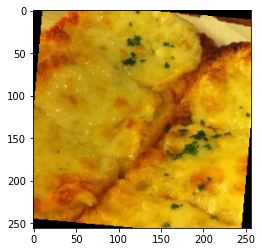

In [ ]:
#check img
data = FoodData()
datax ,datay = data.__getitem__(125)
datax.to(dtype = float)
plt.imshow(datax.permute(1,2,0))

In [ ]:
# Handling the loss func in the output layers
def LossHandle(batch_size ,teacher_out , student_out , student_label , T=20 , alpha =0.5):

  Teacher_out = F.softmax(teacher_out/T)
  Student_softlog_out = F.log_softmax(student_out/T)

  #print("Teacher_out:",Teacher_out.shape,"Student_softlog_out:",Student_softlog_out.shape,"student_out:",student_out.shape)
  Teacher_loss = -(Teacher_out*Student_softlog_out).sum()/batch_size*alpha*T*T #Cross-entropy of teacher&student , do Ave. in batch size
  Student_loss = F.cross_entropy(student_out,student_label)*(1 - alpha) # Cross-entropy of student&student (Cross_entropy fumction 會自動幫你)

  return Teacher_loss + Student_loss

In [ ]:
# Prepare the Teacher/Student-Net
import torchvision.models as models
teacher_net = models.resnet18(pretrained=False, num_classes=11).cuda()
student_net = StudentNet().cuda()

teacher_net.load_state_dict(torch.load('/content/teacher_resnet18.bin')) # load pre_train model data

FileNotFoundError: ignored

In [ ]:
# Prepare the dataloader
training_dataloader = dataloader('training',batch_size = 128)
validation_dataloader = dataloader('validation',batch_size = 128)

In [ ]:
# training optim set
optimizer = optim.AdamW(student_net.parameters(),lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#training start
#param:
epochs = 50
trainloss_record = []
trainacc_record = []
valiloss_record = []
valiacc_record = []

teacher_net.eval() # Teacher Net always be set as Eval-mode
for step in range(epochs):

  loss_train , acc_train , loss_vali , acc_vali ,num_train , num_vali = 0,0,0,0,0,0

  #Training step :
  #print("in train")
  student_net.train()
  for run , data in enumerate(training_dataloader):

    optimizer.zero_grad()
    data_x = data[0].to(device=device)
    data_y = data[1].to(device=device) # Cross entropy func 要吃 Long type int 

    #output
    with torch.no_grad(): #語法記清楚啊阿啊!!!!!
      teacher_out = teacher_net(data_x) #No need to track the gradient of ResNet18~~ (Save the VRAM haha~)
    student_out = student_net(data_x)

    #Loss
    Loss = LossHandle(len(data_x) ,teacher_out=teacher_out , student_out=student_out , student_label= data_y)
    Loss.backward()
    optimizer.step()
    
    # record loss  & acc
    num_train += len(data_x) # Calculate the number of data
    loss_train += Loss*len(data_x) # 因為 loss func 裡有做 Ave. 故這邊要乘以數量才是 batch total loss.
    acc_train += (torch.argmax(F.softmax(student_out),dim = 1) == data_y).sum().item() # Calculate the accuracy
    #print("Loss:",Loss,"Mini-Batch #:",run)

  # Validation Step :
  #print("in vali")
  with torch.no_grad():

    student_net.eval()
    for run_ , data_ in enumerate(validation_dataloader):
      data_x = data_[0].to(device=device )
      data_y = data_[1].to(device=device ) 

      #output
      teacher_out = teacher_net(data_x)
      student_out = student_net(data_x)

      #Loss
      Loss = LossHandle(len(data_x),teacher_out=teacher_out , student_out=student_out , student_label= data_y)

      # record loss  & acc
      num_vali += len(data_x) 
      loss_vali += Loss*len(data_x) 
      acc_vali += (torch.argmax(F.softmax(student_out),dim = 1) == data_y).sum().item() 
      #print("Loss(vali):",Loss,"Mini-Batch(vali) #:",run_)

  trainloss_record.append(loss_train/num_train)
  trainacc_record.append(acc_train/num_train)
  valiloss_record.append(loss_vali/num_vali)
  valiacc_record.append(acc_vali/num_vali)
  print("Now in epoch:{} , loss_train:{}, acc_train:{}, loss_vali:{} ,acc_vali:{}".format(step,loss_train/num_train,acc_train/num_train,loss_vali/num_vali,acc_vali/num_vali))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Now in epoch:0 , loss_train:478.4601135253906, acc_train:0.290796675451044, loss_vali:477.08477783203125 ,acc_vali:0.3338192419825073
Now in epoch:1 , loss_train:476.787109375, acc_train:0.3928643827285627, loss_vali:475.33123779296875 ,acc_vali:0.4145772594752187
Now in epoch:2 , loss_train:475.8507385253906, acc_train:0.4395905128724914, loss_vali:475.5576477050781 ,acc_vali:0.3997084548104956
Now in epoch:3 , loss_train:475.3212585449219, acc_train:0.46563957024123254, loss_vali:474.7596740722656 ,acc_vali:0.44839650145772597
Now in epoch:4 , loss_train:474.5843811035156, acc_train:0.48844516521386583, loss_vali:473.1478576660156 ,acc_vali:0.4921282798833819
Now in epoch:5 , loss_train:474.1636047363281, acc_train:0.5088181633894182, loss_vali:473.827880859375 ,acc_vali:0.5072886297376094
Now in epoch:6 , loss_train:473.8606262207031, acc_train:0.5255422663693493, loss_vali:474.048828125 ,acc_vali:0.49067055393586007
Now in epoch:7 , loss_train:473.43707275390625, acc_train:0.545104

In [ ]:
torch.save(student_net.state_dict(),"Best_student_model.bin")

In [ ]:
#trainloss_record=[ele.item() for ele in trainloss_record]
#trainacc_record=[ele.item() for ele in trainacc_record]
#valiloss_record=[ele.item() for ele in valiloss_record]
#valiacc_record=[ele.item() for ele in valiacc_record]

In [ ]:
print("train loss:",trainloss_record,"vali loss:",valiloss_record)
print("train acc:",trainacc_record,"vali acc:",valiacc_record)

train loss: [478.4601135253906, 476.787109375, 475.8507385253906, 475.3212585449219, 474.5843811035156, 474.1636047363281, 473.8606262207031, 473.43707275390625, 473.054443359375, 472.8722839355469, 472.4893493652344, 472.3711853027344, 472.0757141113281, 471.913330078125, 471.64996337890625, 471.5942687988281, 471.3830261230469, 471.240478515625, 470.91790771484375, 470.7651062011719, 470.7312927246094, 470.62213134765625, 470.4149169921875, 470.29632568359375, 470.1868591308594, 470.0810241699219, 470.0489196777344, 470.0604248046875, 469.99908447265625, 469.8369140625, 469.7655029296875, 469.5405578613281, 469.6247253417969, 469.380859375, 469.3869323730469, 469.40179443359375, 469.27532958984375, 469.2083435058594, 469.13140869140625, 469.0390319824219, 469.02459716796875, 469.069091796875, 468.9729919433594, 468.8880615234375, 468.8283386230469, 468.74761962890625, 468.8601379394531, 468.767333984375, 468.58245849609375, 468.68316650390625] vali loss: [477.08477783203125, 475.3312

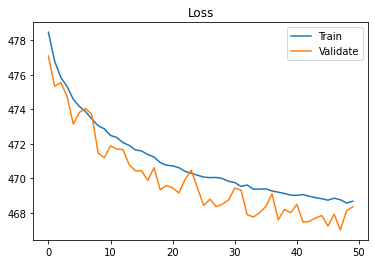

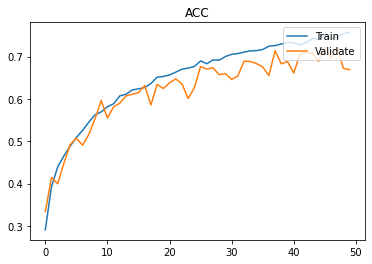

In [ ]:
# Loss curve
step = 50

#Loss
plt.plot(trainloss_record)
plt.plot(valiloss_record)
plt.title('Loss')
plt.legend(["Train","Validate"],loc='upper right')
plt.savefig('loss.png')
plt.show()

#ACC
plt.plot(trainacc_record)
plt.plot(valiacc_record)
plt.title('ACC')
plt.legend(["Train","Validate"],loc='upper right')
plt.savefig('.png')
plt.show()




# Network prouning

In [ ]:
# get dataloader
train_dataloader_p = get_dataloader('training', batch_size=32)
valid_dataloader_p = get_dataloader('validation', batch_size=32)